### Your name:

<pre> Derek Pyne </pre>

### Collaborators:

<pre> None </pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = r"datasets/energy/"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

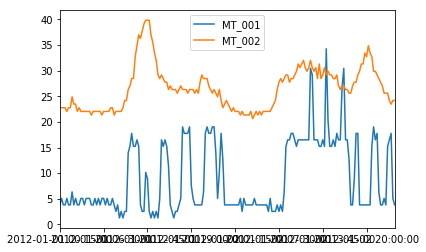

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

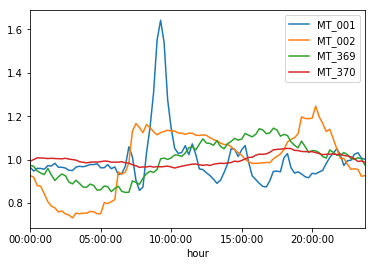

In [20]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [21]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

### 1: (a)
We'll start by writting a little convenience function for fitting kmeans and calculating performance measures.

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
from pandas import Series, DataFrame

def kmeans_clustering(params, X, return_model=False):
    kmeans = KMeans(**params).fit(X)
    labels = kmeans.labels_
    
    results = {'inertia': kmeans.inertia_,
               'silhouette': metrics.silhouette_score(X, labels, metric='euclidean'),
               'params': params}
    if return_model:
        results['model'] = kmeans
    return Series(results)

We can now try a range of hyperparameters and collect the results.

In [23]:
from sklearn.model_selection import ParameterGrid

params = {'n_clusters': range(2, 12)}
kmeans_results = Series(ParameterGrid(params)).apply(kmeans_clustering, X=X)
kmeans_results['n_clusters'] = kmeans_results['params'].apply(lambda x: x['n_clusters'])
kmeans_results

,inertia,params,silhouette,n_clusters
0,1175.527275,{'n_clusters': 2},0.371918,2
1,865.967721,{'n_clusters': 3},0.422447,3
2,657.644266,{'n_clusters': 4},0.429636,4
3,553.829340,{'n_clusters': 5},0.434451,5
4,476.695633,{'n_clusters': 6},0.428388,6
5,426.866277,{'n_clusters': 7},0.266629,7
6,391.537934,{'n_clusters': 8},0.270497,8
7,368.831923,{'n_clusters': 9},0.245507,9
8,347.885388,{'n_clusters': 10},0.219641,10
9,334.704858,{'n_clusters': 11},0.211528,11


Plotting inertia and silhouette score we see that 4 clusters seems like a sweet spot. The silhouette score is near it's make while preferring a smaller number of clusters.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6495572b70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f649547f4a8>], dtype=object)

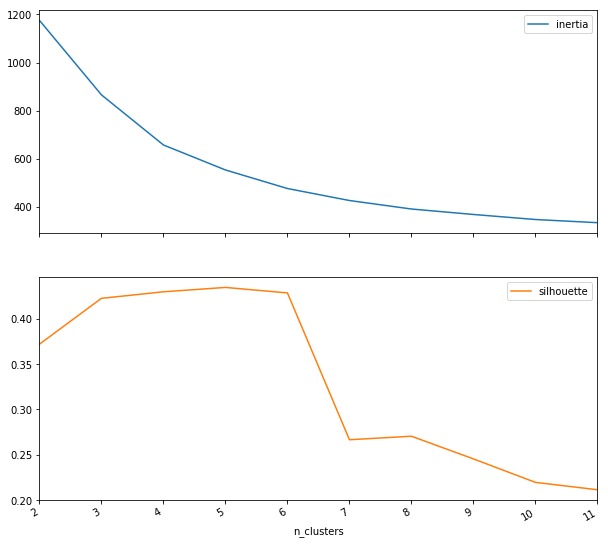

In [24]:
kmeans_results.plot(x='n_clusters', y=['inertia', 'silhouette'], 
                    subplots=True,
                    figsize=(10, 10))

### 1: (b)
We now generate a model using our chosen cluster size. and plot client data for each cluster as well as the centroid.

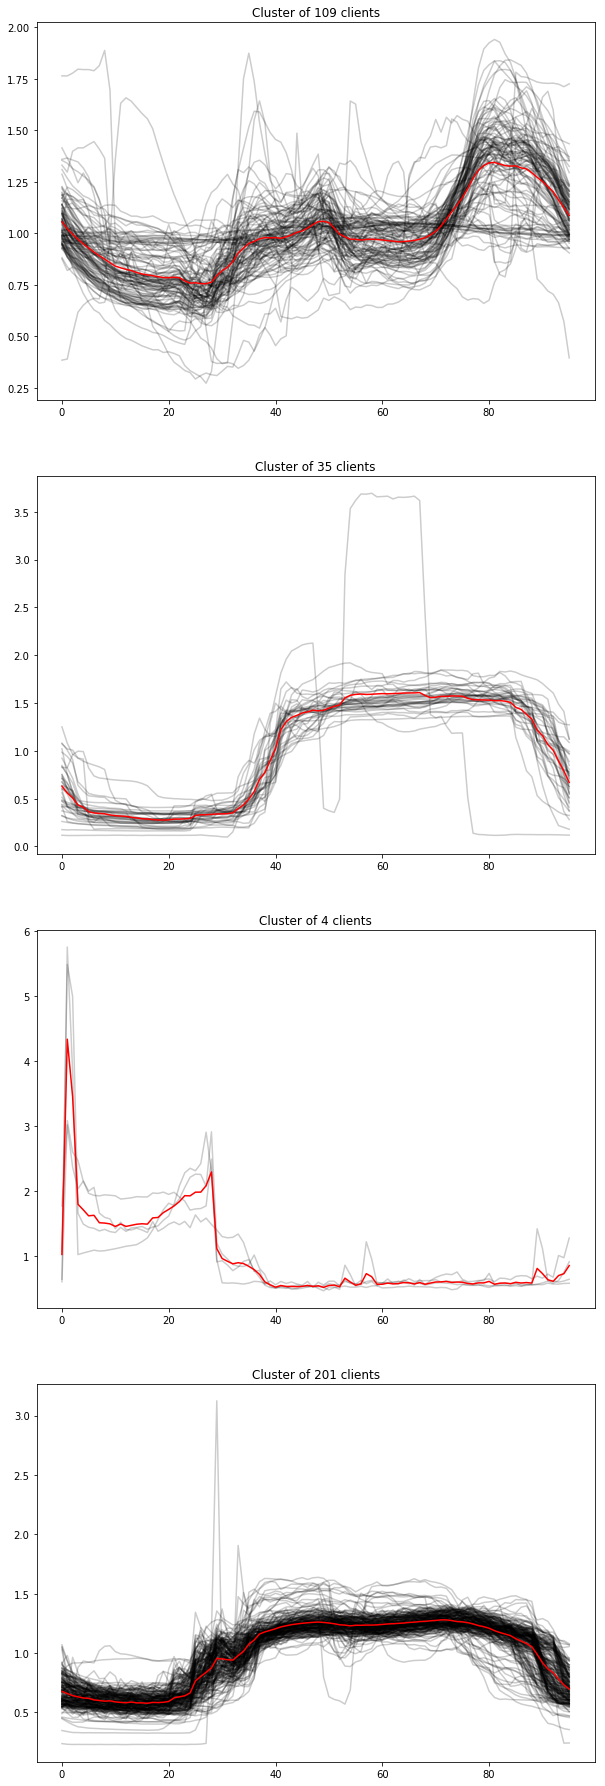

In [25]:
kmeans = kmeans_clustering({'n_clusters': 4}, X, return_model=True)['model']
unique_labels = np.unique(kmeans.labels_)

fig, axs = plt.subplots(len(unique_labels), 1, figsize=(10, 8 * len(unique_labels)))

for (label, ax) in zip(unique_labels, axs):
    mask = kmeans.labels_ == label
    ax.plot(X[mask].T, c='black', alpha=.2)
    ax.plot(X[mask].mean(axis=0), c='red')
    ax.set_title('Cluster of %s clients' % len(X[mask]))
plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [26]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [27]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [28]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

### 2: (a)

We can use the same functions as earlier to fit this data for a single client. Based on our silhouette score it seems like 2 or 3 clusters are the best fit. We'll start with 3 clusters, look at the data, and make a decision from there. 

In [29]:
X = np.array(X)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f645c856a58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f645c8798d0>], dtype=object)

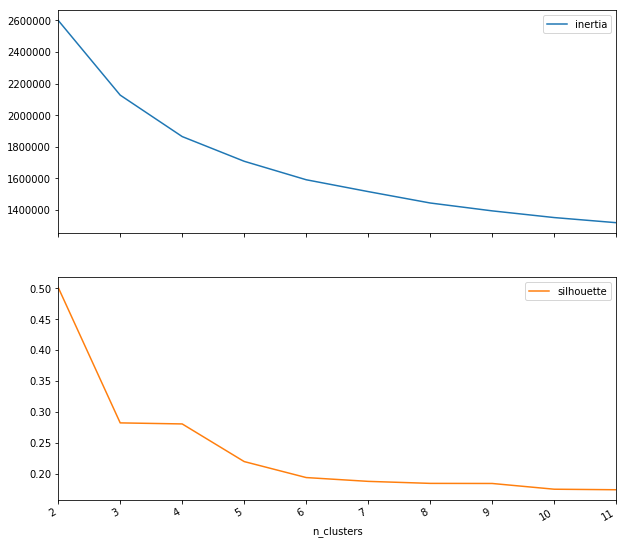

In [30]:
params = {'n_clusters': range(2, 12)}
kmeans_results = Series(ParameterGrid(params)).apply(kmeans_clustering, X=X)
kmeans_results['n_clusters'] = kmeans_results['params'].apply(lambda x: x['n_clusters'])

kmeans_results.plot(x='n_clusters', y=['inertia', 'silhouette'], 
                    subplots=True,
                    figsize=(10, 10))

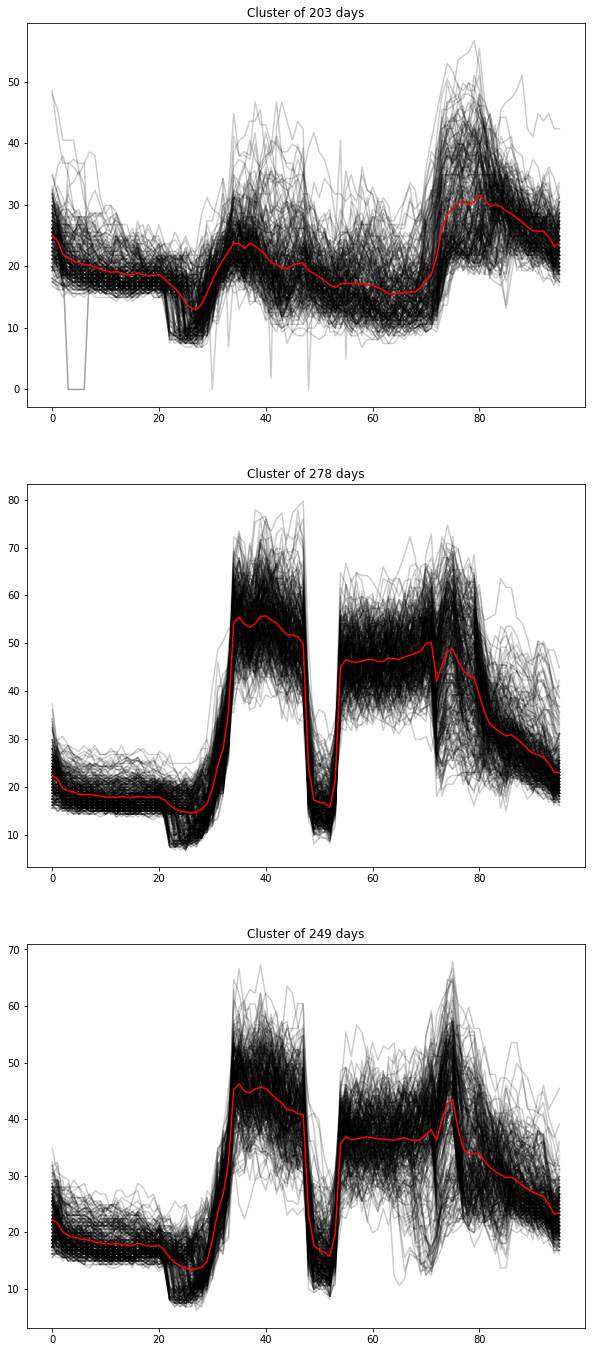

In [31]:
kmeans = kmeans_clustering({'n_clusters': 3}, X, return_model=True)['model']
unique_labels = np.unique(kmeans.labels_)

fig, axs = plt.subplots(len(unique_labels), 1, figsize=(10, 8 * len(unique_labels)))

for (label, ax) in zip(unique_labels, axs):
    mask = kmeans.labels_ == label
    ax.plot(X[mask].T, c='black', alpha=.2)
    ax.plot(X[mask].mean(axis=0), c='red')
    ax.set_title('Cluster of %s days' % len(X[mask]))
plt.show()

We see that our last 2 clusters are almost identical. Let's redo the fit with 2 clusters only.

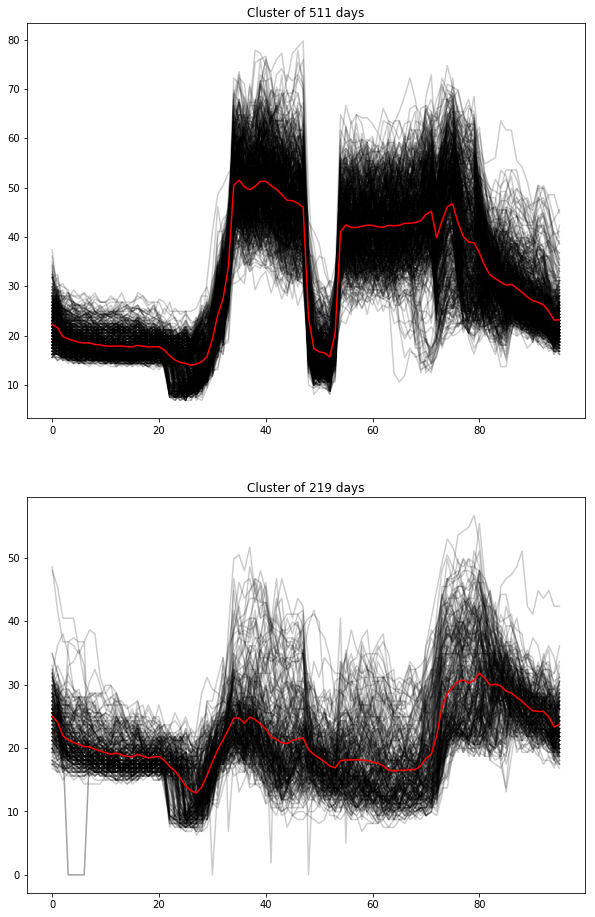

In [32]:
kmeans = kmeans_clustering({'n_clusters': 2}, X, return_model=True)['model']
unique_labels = np.unique(kmeans.labels_)

fig, axs = plt.subplots(len(unique_labels), 1, figsize=(10, 8 * len(unique_labels)))

for (label, ax) in zip(unique_labels, axs):
    mask = kmeans.labels_ == label
    ax.plot(X[mask].T, c='black', alpha=.2)
    ax.plot(X[mask].mean(axis=0), c='red')
    ax.set_title('Cluster of %s days' % len(X[mask]))
plt.show()

### 2: (b)

To interpret these clusters we'll use the provided date array and build a DataFrame for each day and label.

In [33]:
single_client_df = DataFrame({'label': kmeans.labels_, 
                              'date': daysyear})
single_client_df['day_of_week'] = single_client_df['date'].str.split('-').str[0]
single_client_df.head()

,date,label,day_of_week
0,tue-2013-01-01,1,tue
1,wed-2013-01-02,0,wed
2,thu-2013-01-03,0,thu
3,fri-2013-01-04,0,fri
4,sat-2013-01-05,1,sat


We can now conveniently plot this and see that our clustering has split our data in weekdays and weekends!!! Looking back at our plots it seems that weekday usage has `on/off` sections throughout the day with the `on` sections having higher power usage overall. On weekends we have a more consistent lower demand. One theory, is that this might correspond to an office which see's high weekday morning and afternoon usage, a drop during weekday lunch, and low weekend usage. The low weekday lunch usage makes sense here because in Portugal workplaces often shutdown over lunch.

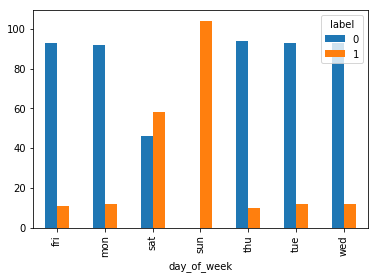

In [34]:
single_client_df.groupby(['label', 'day_of_week'])\
    .size()\
    .unstack()\
    .fillna(0)\
    .T\
    .plot.bar()